In [32]:
# import packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# set the aesthetic style of the plots
sns.set_style()

# filter warning messages
import warnings
warnings.filterwarnings('ignore')


# Assuming feature_importance is your DataFrame
# ... (your code to create and sort feature_importance) ...

# Set options to display all rows and columns
pd.set_option('display.max_rows', None)  # None means unlimited rows
pd.set_option('display.max_columns', None) # None means unlimited columns
pd.set_option('display.width', None)      # None means auto-detect width
pd.set_option('display.max_colwidth', None) # None means unlimited column width


In [33]:
X_processed = pd.read_csv('saved/clustered_data.csv')


In [34]:
import pandas as pd
from imblearn.over_sampling import SMOTE

def apply_smote(df, target_column, random_state=42):
    # Separate features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Apply SMOTE
    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Create a new DataFrame with resampled data
    df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
    df_resampled[target_column] = y_resampled

    return df_resampled

X_processed = apply_smote(X_processed, ['Cluster'])

In [35]:
from sklearn.feature_selection import f_classif

X = X_processed.drop(columns=['Cluster', "target_default"])
y = X_processed['Cluster']

print("Cluster in df_normalized:", 'Cluster' in X_processed.columns)  # Should be True
print("Cluster in X:", 'Cluster' in X.columns)  # Should be False



f_scores, p_values = f_classif(X, y)

# Create a DataFrame to display results
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': f_scores,
    'P-Value': p_values
})

# Sort by F-Score (higher F-Score means more important)
feature_importance = feature_importance.sort_values(by='F-Score', ascending=False)

(feature_importance)

Cluster in df_normalized: True
Cluster in X: False


,Feature,F-Score,P-Value
8,last_borrowed_in_months,4.601587e+06,0.000000e+00
29,credit_utilization,3.858948e+06,0.000000e+00
28,debt_to_income,3.063910e+06,0.000000e+00
36,loan_amount_to_income,3.063910e+06,0.000000e+00
34,credit_available,2.353311e+06,0.000000e+00
7,last_amount_borrowed,2.303732e+06,0.000000e+00
9,credit_limit,1.627102e+06,0.000000e+00
41,last_amount_borrowed_sq,6.202742e+05,0.000000e+00
37,n_accounts_to_credit_limit,3.443351e+05,0.000000e+00
39,credit_utilization_x_fraud_score,4.041749e+04,0.000000e+00


In [36]:
# X = X.drop(columns=["score_2_bin_x_fraud_score_bin", 
#                 "score_1_bin_x_fraud_score_bin",
#                 "score_1_bin_x_score_2_bin",
#                 "score_2_bin",
#                 "score_1_bin"])
X.nunique().sort_values()

facebook_profile                                       2
external_data_provider_credit_checks_last_month        4
fraud_score_bin                                        5
real_state                                             5
score_1                                                7
fraud_score_bin_x_score_1                             20
shipping_state                                        25
score_2                                               35
score_1_sq                                            37
score_1_minus_score_2                                 38
state                                                 50
fraud_score_bin_x_score_2                            112
debt_to_income_x_default_rate                        132
score_1_x_score_2                                    187
n_defaulted_loans                                    192
state_x_real_state                                   193
default_rate                                         226
application_time_in_funnel     

In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69810 entries, 0 to 69809
Data columns (total 57 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   score_1                                          69810 non-null  int64  
 1   score_2                                          69810 non-null  int64  
 2   score_3                                          69810 non-null  float64
 3   score_4                                          69810 non-null  float64
 4   score_5                                          69810 non-null  float64
 5   score_6                                          69810 non-null  float64
 6   risk_rate                                        69810 non-null  float64
 7   last_amount_borrowed                             69810 non-null  float64
 8   last_borrowed_in_months                          69810 non-null  float64
 9   credit_limit                

In [38]:

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.1)
print(len(X_train), len(X_test))
print("NaN in X_train:", X_train.isna().sum().sum())
print("NaN in y_train:", y_train.isna().sum())
print("Infinite values in X:", np.isinf(y_train.values).sum())

62829 6981
NaN in X_train: 0
NaN in y_train: 0
Infinite values in X: 0


In [39]:
X_train_rus, y_train_rus = (X_train, y_train)

f_scores, p_values = f_classif(X_train_rus, y_train_rus)

# Create a DataFrame to display feature importance
yo = pd.DataFrame({'Feature': X_train_rus.columns, 'F-Score': f_scores, 'P-Value': p_values})

# Sort by F-Score (higher F-Score means more important)
feature_importance = yo.sort_values(by='F-Score', ascending=False)

# Print the feature importance
print(feature_importance)

                                            Feature       F-Score  \
8                           last_borrowed_in_months  4.093340e+06   
29                               credit_utilization  3.491892e+06   
28                                   debt_to_income  2.755662e+06   
36                            loan_amount_to_income  2.755662e+06   
34                                 credit_available  2.130486e+06   
7                              last_amount_borrowed  2.080052e+06   
9                                      credit_limit  1.470943e+06   
41                          last_amount_borrowed_sq  5.612935e+05   
37                       n_accounts_to_credit_limit  3.105306e+05   
39                 credit_utilization_x_fraud_score  3.644579e+04   
56                                       score_2_sq  6.794592e+03   
1                                           score_2  6.586786e+03   
50                            score_1_minus_score_2  6.289194e+03   
42                                

       score_1  score_2     score_3     score_4   score_5     score_6  \
1501         0       28  430.000000  104.774337  0.459368   84.604789   
57184        2       24  475.902947   95.915975  0.902485   94.874077   
5552         0       11  550.000000   98.486616  0.639865  111.189685   
49960        3       23  372.045911   96.902324  0.743316   96.151794   
315          0       28  100.000000   98.853098  0.726345   93.491470   
41263        0       21  350.000000  101.279156  0.425003   87.260744   
18117        4       32   80.000000   99.736671  0.374189   95.717235   
64016        3       15  222.883275   98.037837  0.096471  100.461548   
24825        2       14  300.000000   98.503502  0.646715   91.374115   
5612         2       34  350.000000   98.399812  0.960868  104.992751   

       risk_rate  last_amount_borrowed  last_borrowed_in_months  credit_limit  \
1501    0.550000              0.000000                 0.000000     10.135155   
57184   0.333612              0.00

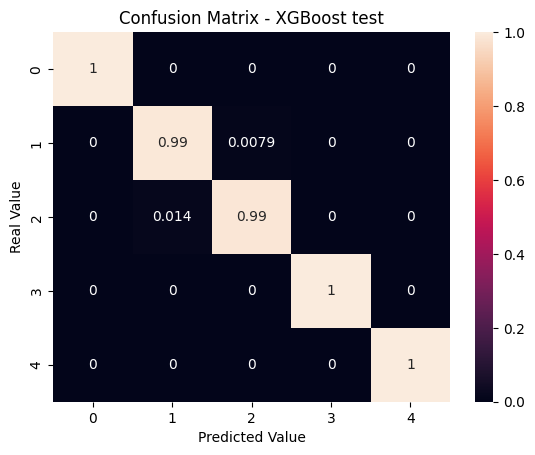

AUC Score: 0.9998329797631292


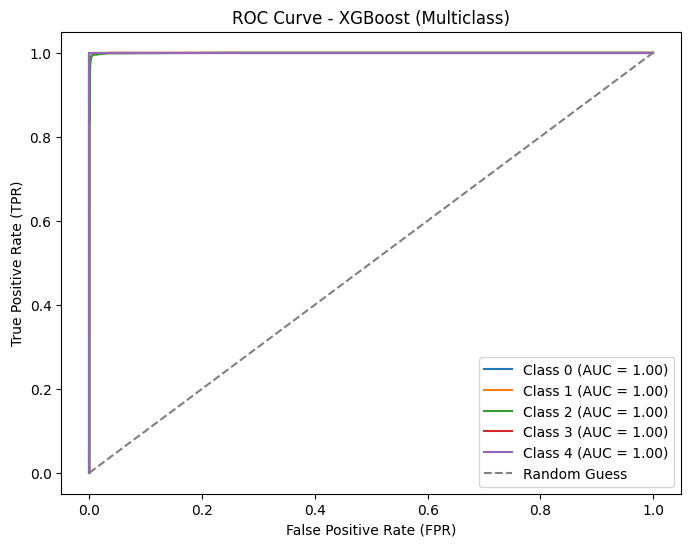

In [40]:
# final XGBoost model
xgb = XGBClassifier(
    max_depth=5, 
    learning_rate=0.01,  
    n_estimators=200, 
    gamma=1,  
    min_child_weight=6,  
    # subsample=0.8,  
    # colsample_bytree=0.8,  
    # reg_lambda=1,  
    # reg_alpha=0.1
)

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# xgb = RandomForestClassifier(
#     n_estimators=200,  # Number of trees in the forest
#     max_depth=8,        # Maximum depth of the trees
#     #... other hyperparameters (e.g., min_samples_split, min_samples_leaf, etc.)...
#     random_state=42,     # For reproducibility
# )

# xgb = AdaBoostClassifier(n_estimators=100, learning_rate=0.01, algorithm='SAMME', random_state=42)  # Adjust parameters
xgb.fit(X_train_rus, y_train_rus)
# prediction
scaler = MinMaxScaler().fit(X_test)
X_test_xgb = X_test #scaler.transform(X_test)
print(X_test_xgb.head(10))
y_pred_xgb = xgb.predict(X_test_xgb)

# classification report
print(classification_report(y_test, y_pred_xgb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_xgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - XGBoost test')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()





from sklearn.preprocessing import label_binarize
y_pred_xgb = xgb.predict_proba(X_test_xgb)
n_classes = len(np.unique(y_test))
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

auc_score = roc_auc_score(y_test_binarized, y_pred_xgb)
print("AUC Score:", auc_score)

# Plot ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_xgb[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_pred_xgb[:, i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - XGBoost (Multiclass)')
plt.legend()
plt.show()

In [41]:
import pickle

# Save label encoders to disk
with open('saved/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb, f)